## Dublin Bike Pre Processing data 

In [1]:
#import necessary libraries and files 
import pandas as pd
import numpy as np
import warnings
import time
import datetime as dt
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import folium
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


%matplotlib inline

In [3]:
data1 = pd.read_csv('dublinbikes_20190401_20190701.csv')
data2 = pd.read_csv('dublinbikes_20190701_20191001.csv')
data3 = pd.read_csv('dublinbikes_20191001_20200101.csv')
data4 = pd.read_csv('dublinbikes_20200101_20200401.csv')
data5 = pd.read_csv('dublinbikes_20180701_20181001.csv')
data6 = pd.read_csv('dublinbikes_20180701_20181001.csv')
data1.sample(5)

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
1151560,46,2019-05-06 20:45:04,2019-05-06 20:41:21,STRAND STREET GREAT,20,8,12,Open,Strand Street Great,53.347080,-6.264192
542370,78,2019-04-17 14:55:03,2019-04-17 14:52:48,MATER HOSPITAL,40,38,2,Open,Mater Hospital,53.359966,-6.264828
1470811,25,2019-05-16 09:00:04,2019-05-16 08:53:27,MERRION SQUARE EAST,30,0,30,Open,Merrion Square East,53.339436,-6.246548
2301154,86,2019-06-10 02:10:02,2019-06-10 02:04:44,PARKGATE STREET,38,9,29,Open,Parkgate Street,53.347973,-6.291804
2188835,34,2019-06-07 11:25:02,2019-06-07 11:17:27,PORTOBELLO HARBOUR,30,27,3,Open,Portobello Harbour,53.330360,-6.265163


In [4]:
#merge data into one table
data = pd.concat([data1,data2, data3,data4])
data = data[data['STATUS'] == 'Open']
data = data[(data['LAST UPDATED'] >= '2019-07-01') & (data['LAST UPDATED'] < '2020-04-01')]
data = data[(data['LAST UPDATED'] < '2019-12-01') | (data['LAST UPDATED'] >= '2020-02-01')]

#remove rows where no update actually occurs
data = data.drop(['TIME'], axis = 1)
data.drop_duplicates(keep= 'first',inplace=True)


#get date and time columns
data['DATETIME'] = [dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["LAST UPDATED"]]
data['LAST UPDATED'] = [dt.datetime.time(d) for d in data['DATETIME']] 
data['DATE'] = [dt.datetime.date(d) for d in data['DATETIME']] 
data['date_for_merge'] = data['DATETIME'].dt.round('H')

#create important features
data['OCCUPANCY_PCT'] =  data['AVAILABLE BIKES'] / data['BIKE STANDS']
data['FULL'] = np.where(data['OCCUPANCY_PCT'] == 0, 1,0 )
data['EMPTY'] = np.where(data['OCCUPANCY_PCT'] == 1, 1,0 )

### create time aggregates needed for clustering
# weekday/saturday/sunday
data['DAY_NUMBER'] = data.DATETIME.dt.dayofweek
data['DAY_TYPE'] = np.where(data['DAY_NUMBER'] <= 4, 'Weekday', (np.where(data['DAY_NUMBER'] == 5, 'Saturday', 'Sunday')))

def bin_time(x):
    if x.time() < dt.time(6):
        return "Overnight "
    elif x.time() < dt.time(11):
        return "6AM-10AM "
    elif x.time() < dt.time(16):
        return "11AM-3PM "
    elif x.time() < dt.time(20):
        return "4PM-7PM "
    elif x.time() <= dt.time(23):
        return "8PM-11PM "
    else:
        return "Overnight "


data["TIME_TYPE"] = data['DATETIME'].apply(bin_time)
data['HOUR'] = data['DATETIME'].dt.hour
data['MONTH'] = data['DATETIME'].dt.month
data['CLUSTER_GROUP'] = data['TIME_TYPE'] + data['DAY_TYPE']

data.sample(5)

,STATION ID,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE,...,date_for_merge,OCCUPANCY_PCT,FULL,EMPTY,DAY_NUMBER,DAY_TYPE,TIME_TYPE,HOUR,MONTH,CLUSTER_GROUP
1655384,48,08:17:57,EXCISE WALK,40,22,17,Open,Excise Walk,53.347778,-6.244239,...,2020-03-14 08:00:00,0.425,0,0,5,Saturday,6AM-10AM,8,3,6AM-10AM Saturday
1744987,16,06:56:38,GEORGES QUAY,20,6,14,Open,Georges Quay,53.347507,-6.252192,...,2019-11-25 07:00:00,0.700,0,0,0,Weekday,6AM-10AM,6,11,6AM-10AM Weekday
2395093,98,04:30:32,FREDERICK STREET SOUTH,40,40,0,Open,Frederick Street South,53.341515,-6.256853,...,2019-09-13 05:00:00,0.000,1,0,4,Weekday,Overnight,4,9,Overnight Weekday
2070722,4,22:18:35,GREEK STREET,20,0,20,Open,Greek Street,53.346874,-6.272976,...,2020-03-28 22:00:00,1.000,0,1,5,Saturday,8PM-11PM,22,3,8PM-11PM Saturday
424072,32,11:19:11,PEARSE STREET,30,17,12,Open,Pearse Street,53.344303,-6.250427,...,2019-10-14 11:00:00,0.400,0,0,0,Weekday,11AM-3PM,11,10,11AM-3PM Weekday


In [ ]:
#Selecting the stations 
#selected_stations = [68,78,83,85,88,97]

### Time cluster 

In [6]:
#group data into clusters
clustering_df = data[['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'DAY_TYPE', 'TIME_TYPE', 'OCCUPANCY_PCT','CLUSTER_GROUP']]
clustering_df = clustering_df.groupby(['STATION ID', 'NAME', 'LATITUDE', 'LONGITUDE', 'CLUSTER_GROUP'],as_index=False)['OCCUPANCY_PCT'].mean()
clustering_df  = clustering_df.set_index('STATION ID')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['NAME', 'STATION ID','LATITUDE', 'LONGITUDE'] , columns=['CLUSTER_GROUP'], values='OCCUPANCY_PCT')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df .set_index('NAME')
clustering_df = clustering_df.dropna()

clustering_df.sample(5)

CLUSTER_GROUP,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday
NAME,,,,,,,,,,,,,,,,,,
MERRION SQUARE SOUTH,113,53.338615,-6.248606,0.126665,0.116924,0.767009,0.136331,0.140321,0.319082,0.115807,0.095377,0.461904,0.113148,0.139763,0.087761,0.095369,0.100433,0.071652
BROADSTONE,116,53.354698,-6.272314,0.124062,0.097149,0.129675,0.107062,0.119892,0.134975,0.145695,0.115686,0.147453,0.113109,0.113919,0.177884,0.151235,0.118605,0.169394
ORMOND QUAY UPPER,29,53.346058,-6.268001,0.842383,0.823588,0.319453,0.854031,0.857021,0.315755,0.634455,0.768991,0.191126,0.874768,0.703741,0.352273,0.620833,0.718031,0.199344
EXCISE WALK,48,53.347778,-6.244239,0.400951,0.412112,0.568632,0.360360,0.469494,0.597736,0.327519,0.332646,0.326216,0.308432,0.492516,0.283427,0.278681,0.329109,0.223232
ST. JAMES HOSPITAL (CENTRAL),81,53.339985,-6.295594,0.327184,0.253759,0.170535,0.301797,0.202670,0.216308,0.312617,0.278001,0.264216,0.250742,0.203689,0.266057,0.263467,0.228335,0.303053


## K-means clustering analysis 

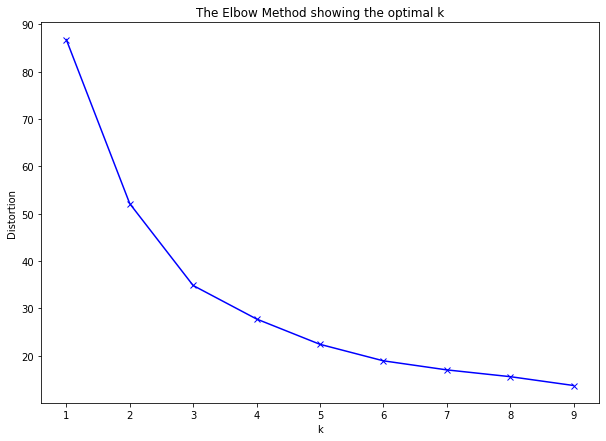

In [7]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [8]:
#clustering algo
X = np.array(clustering_df.drop(['STATION ID', 'LATITUDE', 'LONGITUDE'], 1).astype(float))
KM = KMeans(n_clusters=5) 
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['Cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

CLUSTER_GROUP,NAME,STATION ID,LATITUDE,LONGITUDE,11AM-3PM Saturday,11AM-3PM Sunday,11AM-3PM Weekday,4PM-7PM Saturday,4PM-7PM Sunday,4PM-7PM Weekday,6AM-10AM Saturday,6AM-10AM Sunday,6AM-10AM Weekday,8PM-11PM Saturday,8PM-11PM Sunday,8PM-11PM Weekday,Overnight Saturday,Overnight Sunday,Overnight Weekday,Cluster
0,AVONDALE ROAD,108,53.359406,-6.276142,0.159102,0.126197,0.107060,0.208063,0.183721,0.247766,0.279970,0.168737,0.154918,0.206872,0.252699,0.369088,0.390925,0.243118,0.421789,3
1,BARROW STREET,70,53.341656,-6.236198,0.457221,0.129602,0.703599,0.091699,0.502551,0.163900,0.593277,0.249084,0.730308,0.119338,0.753040,0.218540,0.287356,0.247592,0.315751,1
2,BENSON STREET,90,53.344154,-6.233451,0.178727,0.142477,0.655158,0.125685,0.142831,0.091801,0.225119,0.190721,0.735708,0.134686,0.166334,0.059702,0.093759,0.161444,0.109268,1
3,BLACKHALL PLACE,88,53.348801,-6.281637,0.375960,0.442651,0.131210,0.439610,0.480735,0.409125,0.559444,0.566730,0.237267,0.556918,0.625755,0.760816,0.730187,0.657854,0.828303,0
4,BLESSINGTON STREET,2,53.356770,-6.268140,0.177049,0.079175,0.118073,0.170406,0.188239,0.248699,0.164333,0.129490,0.161376,0.206522,0.278690,0.482975,0.420940,0.282905,0.545053,3


In [9]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.345, -6.2650], zoom_start=13.5)
for LATITUDE, LONGITUDE, Cluster in zip(locations['LATITUDE'],locations['LONGITUDE'], locations['Cluster']):
    folium.CircleMarker(
        [LATITUDE, LONGITUDE],
        color = 'b',
        radius = 8,
        fill_color=colordict[Cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map
    

Based on the mat the location stations choosen were: 
- 'HANOVER QUAY' in Grand Canal Dock 
- 'FITZWILLIAM SQUARE EAST' in south Dublin 
- 'ST JAMES HOSPITAL (LUAS)'- south Dublin residential area 

In [ ]:
#df.drop(columns=["ADDRESS","LATITUDE","LONGITUDE","LAST UPDATED","NAME","STATION ID","AVAILABLE BIKE STANDS","STATUS"],axis=1,inplace=True)
#df["TIME"]=pd.to_datetime(df["TIME"])  
#df.sort_values(by=['TIME'],inplace=True)
#df["GAP AMOUNT"]=df["TIME"].diff().dt.seconds/60

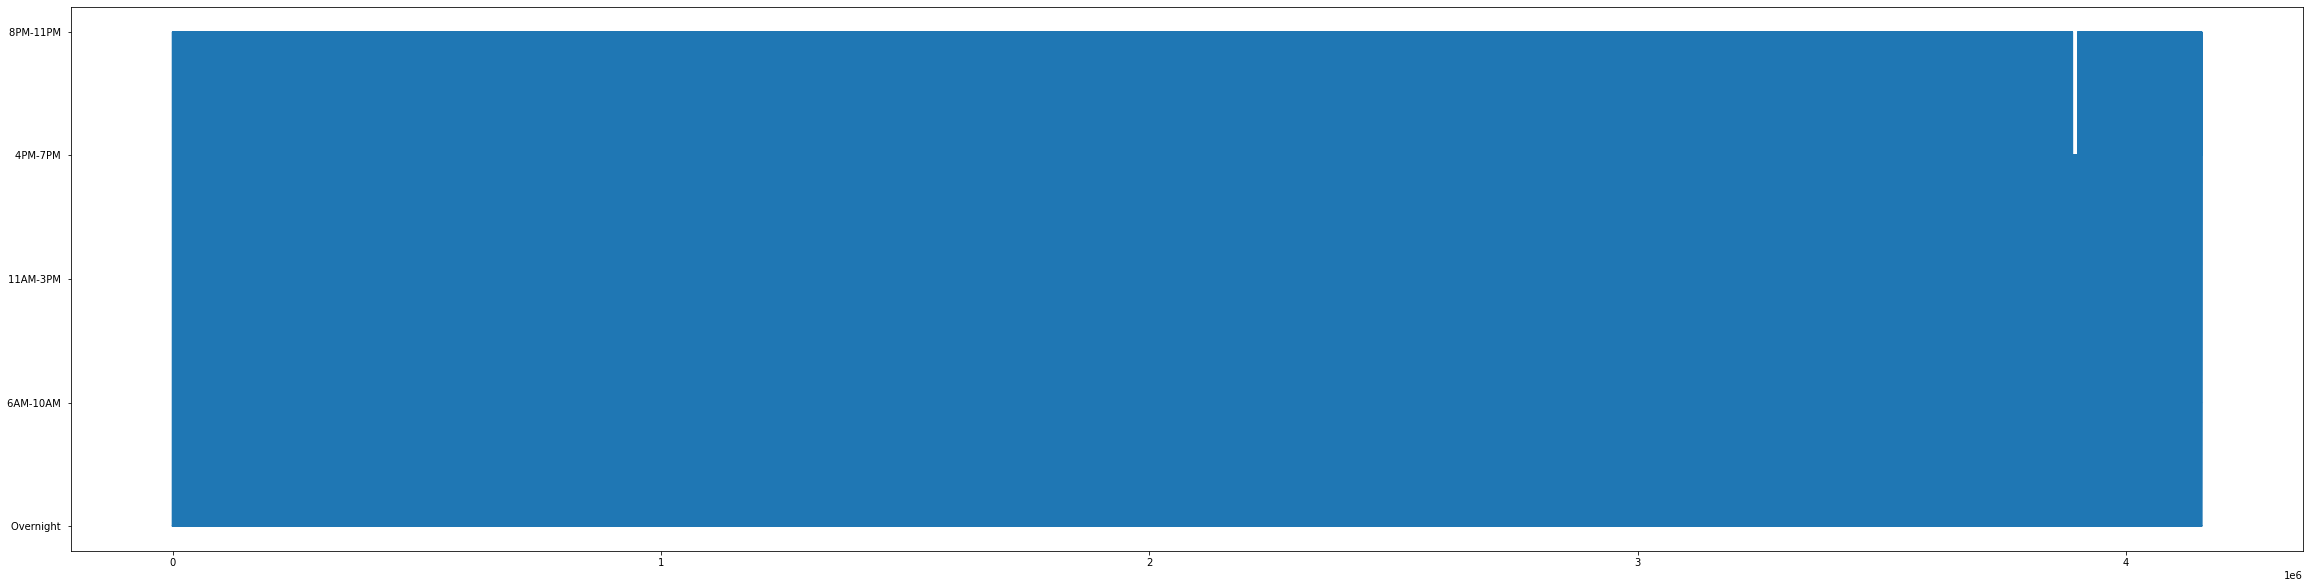

In [11]:
fig,ax = plt.subplots(1, 1, figsize=(40, 10))
ax.plot(range(0,len(data['AVAILABLE BIKES'])),data["TIME_TYPE"])
plt.show()